# Prudential Life Insurance Assessment

Prudential Life Insurance Assessment fue una competición publicada en [kaggle](https://www.kaggle.com/c/prudential-life-insurance-assessment/overview) hace aproximadamente 5 años. El modelo con el mejor rendimiento obtuvo un premio de 15,000 USD, y en total se repartieron premios por un monto de 30,000 USD

[Prudential Life Insurance](https://www.prudential.com/#invest) es una de las aseguradoras más grandes y con mayor experiencia de USA, y desde hace algunos años se encuentra reclutando científicos de datos para resolver problemas desafiantes que los ayudan a identificar oportunidades de negocio.

## Resumen de la competición

* __Contexto__: 

Vivmos en un mundo en donde podemos comprar artículos con sólo un click. Es decir, un proceso lento para comprar un seguro de vida potencialmente puede reducir el flujo de nuevo negocio. 

* __Problema__:

¿Cuál es el resultado de esto? Las personas promedio no muestran un particular interés por tener un seguro de vida, consideran que el proceso es lento y finalmente desisten. 

* __Objetivo__:

Prudential quiere acelerar el proeso para mejorar la experiencia de usuario, y de este modo aumentar la taza de conversión de nuevos clientes.

* __Propuesta de solución__: 

Desarrollar un modelo predictivo que clasifique con presición el riesgo mediante un enfoque automatizado y en función de los datos.



## Datos

En este conjunto de datos, se proporcionan más de cien variables que describen los atributos de los solicitantes de seguros de vida. 

La tarea es predecir la variable "Respuesta" para cada Id en el conjunto de prueba.
La "respuesta" es una variable categóriga que clasifica el riesgo en 8 niveles.

No obstante, y para simplificar el problema, tomaremos sólo los valores extremos 8 y 1.

In [1]:
%%writefile utilities.py

def get_cols_wnull(df):
    null_columns = df.isna().sum(axis = 0).sort_values(ascending = False)
    null_columns= null_columns[null_columns>0]/df.shape[0]
    return null_columns

def drop_nan_cols(df, threshold):
    null_columns = get_cols_wnull(df)
    cols_to_drop = null_columns[null_columns>threshold].index
    df = df.drop(cols_to_drop, axis = 1)
    return df

Overwriting utilities.py


In [2]:
import numpy as np
import pandas as pd
from utilities import *
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_theme()

train = pd.read_csv("./data/shortset/train.csv")
train.set_index('Id', inplace = True)
train.index.name = None
train.head()

,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,0.148536,...,0,0,0,0,0,0,0,0,0,0
6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,0.288703,...,0,0,0,0,0,0,0,0,0,0
7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,0.205021,...,0,0,0,0,0,0,0,0,0,0
8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,0.234310,...,0,0,0,0,0,0,0,0,0,0
10,1,D2,26,0.230769,3,1,1,0.507463,0.836364,0.299163,...,0,0,0,0,0,0,0,0,0,0


## Limpieza de Datos


### Datos Nulos

In [3]:
train = drop_nan_cols(df = train, threshold = 0.3)

null_columns_stats = pd.concat(
    [train[get_cols_wnull(train).index].describe().apply(lambda x: round(x,2)).transpose(),
     get_cols_wnull(train).to_frame(name = "null share")], axis = 1)

null_columns_stats

,count,mean,std,min,25%,50%,75%,max,null share
Family_Hist_4,18516.0,0.43,0.16,0.0,0.31,0.41,0.55,0.94,0.279421
Employment_Info_6,20863.0,0.36,0.35,0.0,0.05,0.25,0.55,1.00,0.188084
Medical_History_1,21581.0,8.33,12.97,0.0,2.00,4.00,10.00,239.00,0.160142
Employment_Info_4,23024.0,0.01,0.03,0.0,0.00,0.00,0.00,1.00,0.103985
Employment_Info_1,25680.0,0.08,0.08,0.0,0.03,0.06,0.10,1.00,0.000623


Antes de rellenar los valores nulos, veamos la distribución de alguna de las variables con más datos nulos.

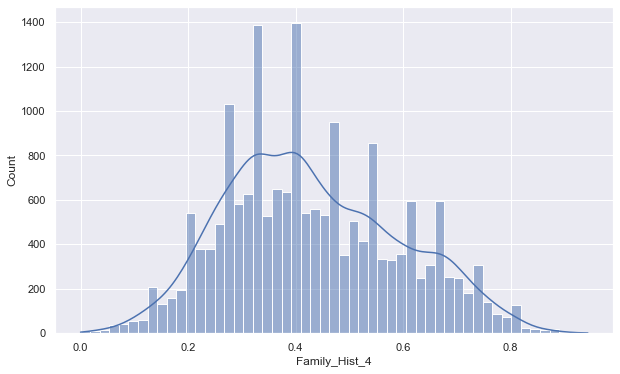

In [4]:
plt.figure(figsize=(10, 6))
plot = sns.histplot(data = train, x = "Family_Hist_4", kde = True)

In [5]:
train = train.apply(lambda x: x.fillna(np.mean(x)) if x.dtype == "float64" else x, axis = 1)

### Correlación con variable `Response`

Al momento de hacer un modelo para predecir la variable `Response`, no hay que perder de vista que en el fondo estamos buscando asociaciones con el resto de variables y un método para extrapolar las relaciones a datos no vistos por el algoritmo.

In [6]:
train_corr = train.corr()

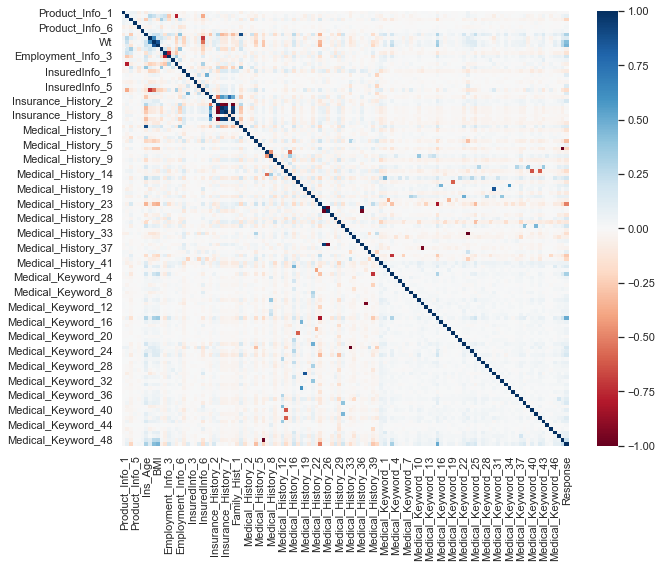

In [7]:
fig, ax = plt.subplots(figsize = (10, 8))
ax = sns.heatmap(train_corr, vmin = -1, vmax = 1, center = 0,cmap = "RdBu", ax = ax)

Muchos datos, y pocos de ellos parecen estar fuertemente asociados a la variable `Response`, procuremos focalizarnos en aquellas variables con un mayor grado de asociación a la variable de interés. 

In [8]:
train_corr = train_corr['Response'].to_frame(name = "correlation")

In [9]:
def filter_unrel_cols(df, df_corr, threshold):
    corr_cols = df_corr[(df_corr['correlation']>=threshold) | (df_corr['correlation']<=-threshold)].index
    return df[corr_cols]

Para lograrlo, filtraremos sólo aquellas columnas con un coeficiente de correlación mayor a 0.2 o menor a -0.2

In [10]:
X = filter_unrel_cols(train, train_corr, threshold = 0.2)

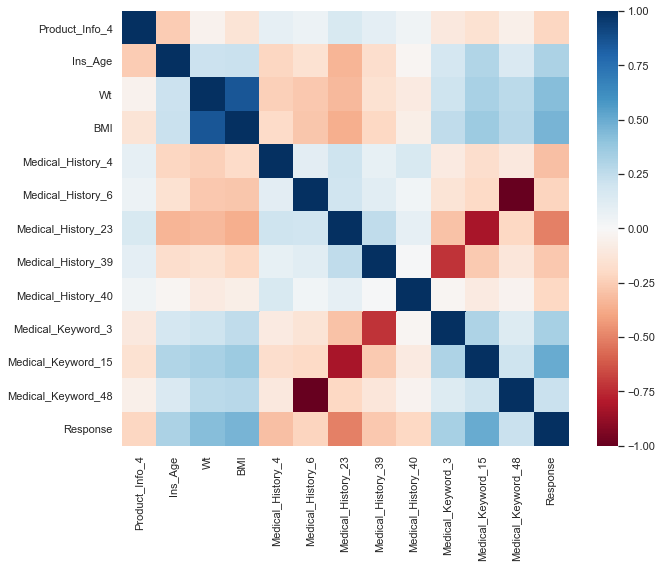

In [255]:
fig, ax = plt.subplots(figsize = (10, 8))
ax = sns.heatmap(
    X.corr(), vmin = -1, vmax = 1, center = 0,cmap = "RdBu", ax = ax)

Podemos ver que existen algunas relaciones interesantes, exploremos los resultados con detenimiento.

#### Product_Info_4

In [11]:
def box_plot_upgraded(df, x , y, ax):
    ax = sns.boxplot(ax = ax, data = df , y = y, x = x,
                 boxprops= {"alpha":.3},  whis = np.inf)
    ax = sns.stripplot(ax = ax, x = x, y = y, data = df, alpha = 0.1)

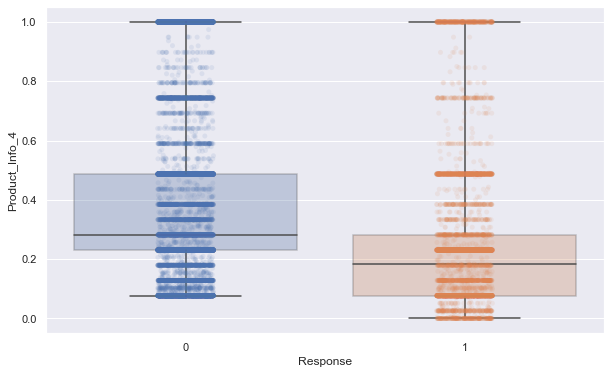

In [12]:
fig, axes = plt.subplots(figsize = (10,6))
box_plot_upgraded(df = X, x = "Response" , y = "Product_Info_4", ax = axes)

Podríamos ver que en promedio, los valores más altos de `Product_Info_4` suelen ser lo que terminan siendo rechazados. 
Quizás `Product_Info_4` es una variable relacionada al precio de la póliza.

Vamos a generar un gráfico para cada una de las variables con un tipo de dato `float64`.

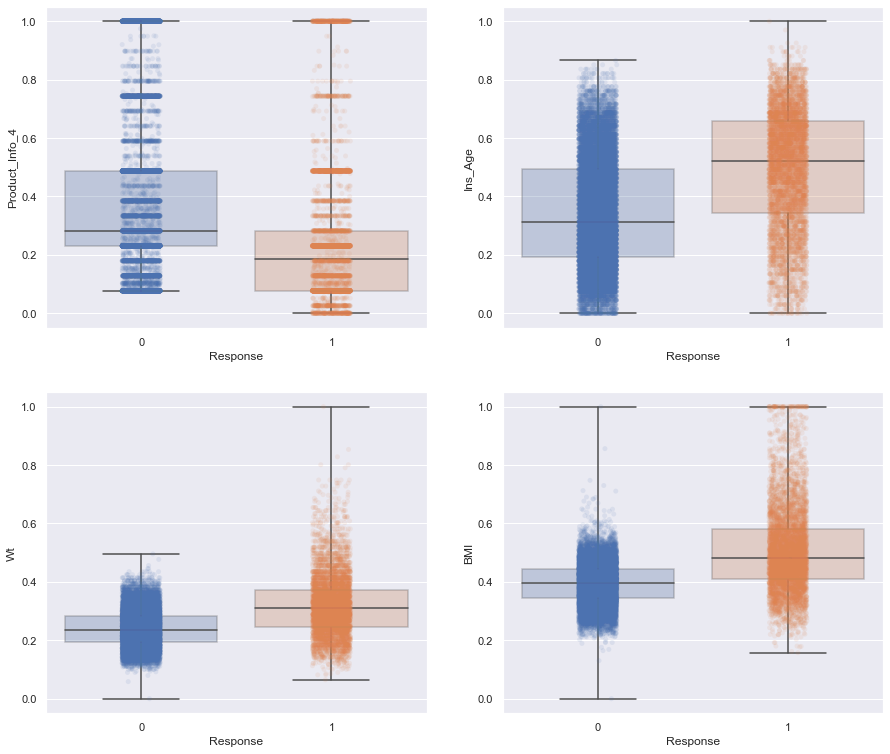

In [13]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 13))
columns = X.select_dtypes("float64").columns
columns = np.array(columns).reshape(2,2)
for i in range(0,2):
    for j in range(0,2):
        box_plot_upgraded(ax = axes[i][j], df = X, x = "Response" , y = columns[i][j] )

Antes de continuar, veamos qué tipo de dato son el resto de variables.

In [14]:
X.dtypes

Product_Info_4        float64
Ins_Age               float64
Wt                    float64
BMI                   float64
Medical_History_4       int64
Medical_History_6       int64
Medical_History_23      int64
Medical_History_39      int64
Medical_History_40      int64
Medical_Keyword_3       int64
Medical_Keyword_15      int64
Medical_Keyword_48      int64
Response                int64
dtype: object

Las variables con un valor `int64` son en realidad variables categóricas con sólo dos valores. Parece que el set de datos venía ya *dummyificado*.

In [15]:
X = X.apply(lambda x: x.astype(dtype = "category") if 'Medical_' in x.name or x.name == "Response" else x)

In [16]:
X.dtypes

Product_Info_4         float64
Ins_Age                float64
Wt                     float64
BMI                    float64
Medical_History_4     category
Medical_History_6     category
Medical_History_23    category
Medical_History_39    category
Medical_History_40    category
Medical_Keyword_3     category
Medical_Keyword_15    category
Medical_Keyword_48    category
Response              category
dtype: object

Ahora exploraremos el comportamiento de la variable `Response` en función de las variables categóricas.

In [17]:
def heatmap_upgraded(ax,df, x, y):
    cross_table = pd.crosstab(df[x],df[y])
    cross_table = cross_table/cross_table.sum().sum()
    cross_table = cross_table.apply(lambda x: round(x,4))
    sns.heatmap(
        cross_table,
        annot=True ,cmap='Blues', fmt='g', ax = ax)
    

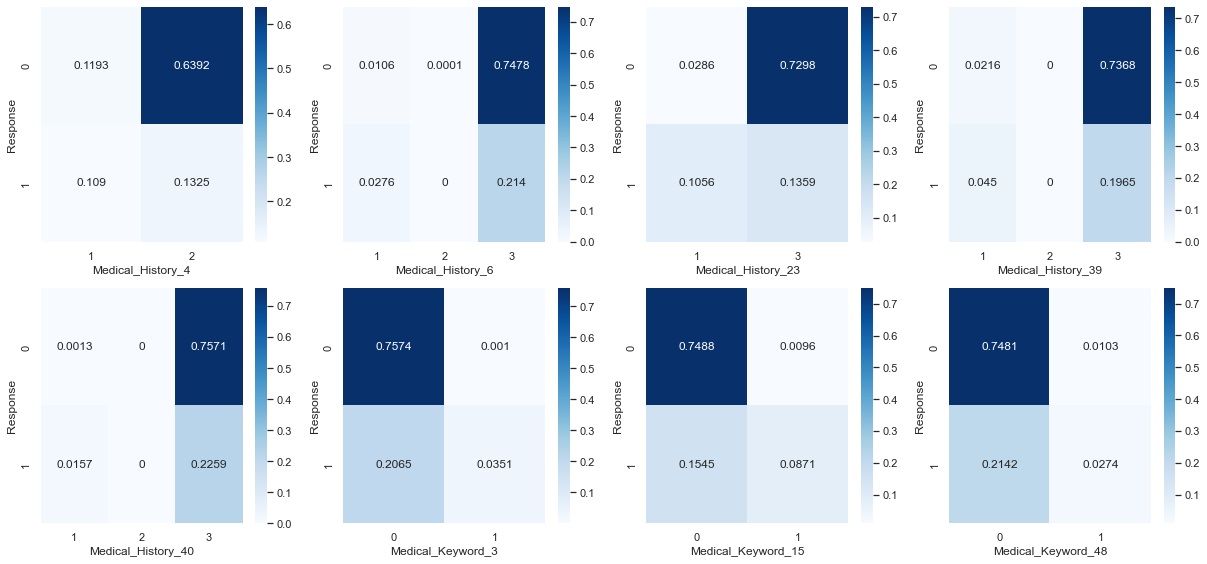

In [18]:
cat_columns = X.select_dtypes('category').columns
cat_columns = [col for col in cat_columns if col!='Response' ]
cat_columns = np.array(cat_columns).reshape(2,4)
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (17, 8))
for i in range(0,2):
    for j in range(0,4):
        heatmap_upgraded(ax = axes[i][j], df = X, x = "Response" , y = cat_columns[i][j] )
plt.tight_layout()

Como último paso filtraremos aquellos valores atípicos porque podrían meter ruido en nuestra estimación.

In [19]:
X = X[(X['Medical_History_40']!=2) & (X['Medical_History_39']!=2)].copy()

## Modelo

En este caso etamos hablando de ajustar el modelo a una variable categórica, por lo que una buena y primera opción podría ser un modelo de [Regresión Logística](https://es.wikipedia.org/wiki/Regresi%C3%B3n_log%C3%ADstica).

Sin entrar mucho en los detalles, un modelo de regresión logística es un caso particular de la familia de los modelos lineales generalizados, que usa como función liga la función [logit](https://es.wikipedia.org/wiki/Logit) y asume una distribución subyacente [Binomial](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_binomial) para la variable objetivo, i.e. $Y$.

Para la implementación en Python, utilizaremos un par de cosas nuevas:

1. [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html): La clase de `sklearn` para ajustar un modelo de regresión logística.
<br>
<br>
2. [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html): Un clase que nos ayuda a estandarizar nuestros datos para acelerar el proceso de ajuste y forzar el supuesto de distribución normal de las $\beta$'s mediante:
    + Centrar la distribución de nuestras variables en 0
    + Escalar la varianza a 1
<br> 
<br>
3. [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html): nos ayuda a definir un proceso para concatenar transformaciones y estimadores, e.g. `StandardScaler` + `LogisticRegression`.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X.drop('Response', axis = 1), X['Response'], test_size=0.30,random_state=101)

In [22]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

### Valores de los Coeficientes

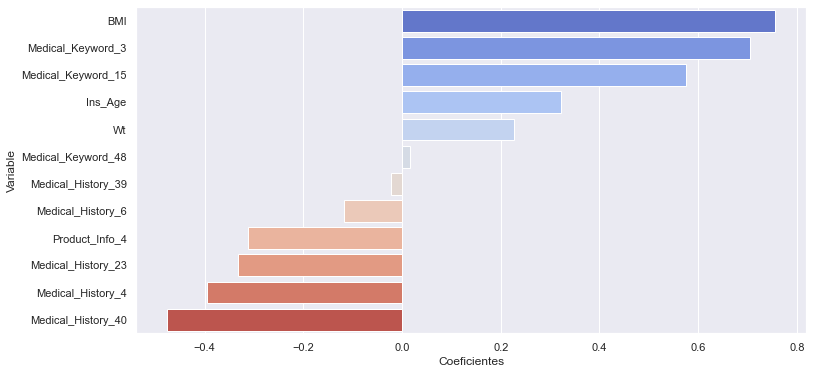

In [23]:
coeficientes = pd.DataFrame(
    data = {
        'Variable': X_train.columns,
        'Coeficientes': pipe['logisticregression'].coef_[0]
    }).sort_values('Coeficientes', ascending = False) 
fig, ax = plt.subplots(figsize = (12,6))
ax = sns.barplot(data = coeficientes, y ="Variable", x = "Coeficientes", palette="coolwarm")

### Evaluación del modelo

In [24]:
predictions = pipe.predict(X_test)
_to_corr = pd.DataFrame(
    data = {
        'Response':y_test.values,
        'Predictions': predictions})
conf_matrix = pd.crosstab(_to_corr["Predictions"], _to_corr["Response"])
print("Confusion Matrix - Valores Absolutos")
display(conf_matrix)
conf_matrix = conf_matrix/conf_matrix.sum().sum()
print("Confusion Matrix - Valores Relativos")
display(conf_matrix.apply(lambda x: round(x,2)))

Confusion Matrix - Valores Absolutos


Response,0,1
Predictions,,
0,5668,756
1,174,1110


Confusion Matrix - Valores Relativos


Response,0,1
Predictions,,
0,0.74,0.10
1,0.02,0.14


In [25]:
acc = round(pipe.score(X_test, y_test)*100,3)
print("Aciertos: {}%".format(acc))

Aciertos: 87.935%
